# Scaling factor between random and optimization with respect to the determinant

In [142]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
from qdots_qll.models import game
import qutip as qt
from qbism import sic_povm

from models_scratch_for_drafting import (
    single_qdot,
    vec,
    two_qdots_identity_for_systemB,
)

true_pars = game.true_pars
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]

from matplotlib import rcParams

rcParams["font.family"] = "Inter"

In [10]:
simplest_povm_A = (
    jnp.array(
        [
            [0.5 * (qt.identity(2) + mat), 0.5 * (qt.identity(2) - mat)]
            for mat in [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
        ]
    ).reshape(-1, 2, 2)
    / 3
)

In [8]:
m_singledot = single_qdot(simplest_povm_A)

In [2]:
# model = game.physical_model()
# true_pars = game.true_pars

In [36]:
qt.ket2dm((qt.basis(2, 0) + qt.basis(2, 1)).unit())

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]

In [95]:
plus_dm = vec(qt.ket2dm((qt.basis(2, 0) + qt.basis(2, 1)).unit()).full())
excited_dm = vec(
    qt.ket2dm((0 * qt.basis(2, 0) + qt.basis(2, 1)).unit()).full()
)
# print(dm_gstate)

In [97]:
from scipy.optimize import curve_fit

times = jnp.linspace(0, 100, 1000)


lkl_plus_dm = jax.vmap(
    lambda t: m_singledot.likelihood_particle(true_pars, t, plus_dm)
)(times)

lkl_excited_dm = jax.vmap(
    lambda t: m_singledot.likelihood_particle(true_pars, t, excited_dm)
)(times)


def T2_exp_decay(t, T2):
    y = 0.5 * (1 - np.exp(-t / T2))
    return y


def T1_exp_decay(t, T1):
    y = 0.5 * (1 + np.exp(-t / T1))
    return y


t2_estimate, _ = curve_fit(
    T2_exp_decay, np.array(times), np.array(lkl_plus_dm)[:, 1] * 3
)

T1 time around 25
T2 is [11.34162144]


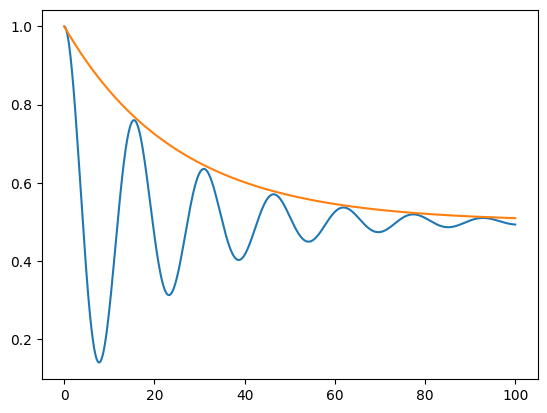

In [105]:
plt.plot(times, lkl_excited_dm[:, 5] * 3)
plt.plot(times, T1_exp_decay(times, 25))

print("T1 time around 25")
print(f"T2 is {t2_estimate}")

In [128]:
times = jnp.linspace(0, 100, 1000)

initial_dm = excited_dm

evolved_lkl = jax.vmap(
    lambda t: m_singledot.likelihood_particle(true_pars, t, initial_dm)
)(times)

fim_times = jax.vmap(lambda t: m_singledot.fim(true_pars, t, initial_dm))(
    times
)

qfim_times = jax.vmap(lambda t: m_singledot.qfim(true_pars, t, initial_dm))(
    times
)

det_fim_times = jax.vmap(lambda fim_i: jnp.linalg.det(fim_i))(fim_times)


# plt.plot(times, evolution_fim[:, 2, 2], label="fim")
# # plt.plot(times, evolution_qfim[:, 0, 0], label="qfim")


# plt.legend()
# plt.show()

(-1.0, 1.0)

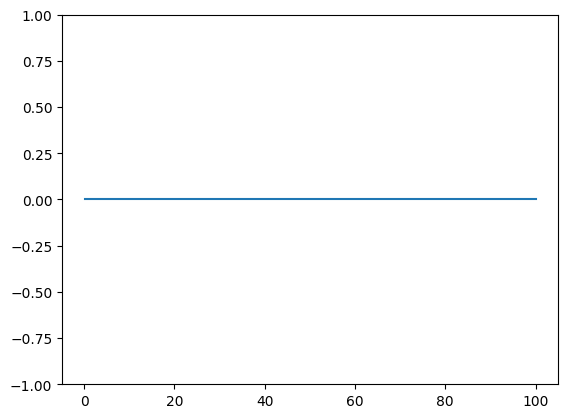

In [129]:
plt.plot(times, det_fim_times)
plt.ylim(-1, 1)

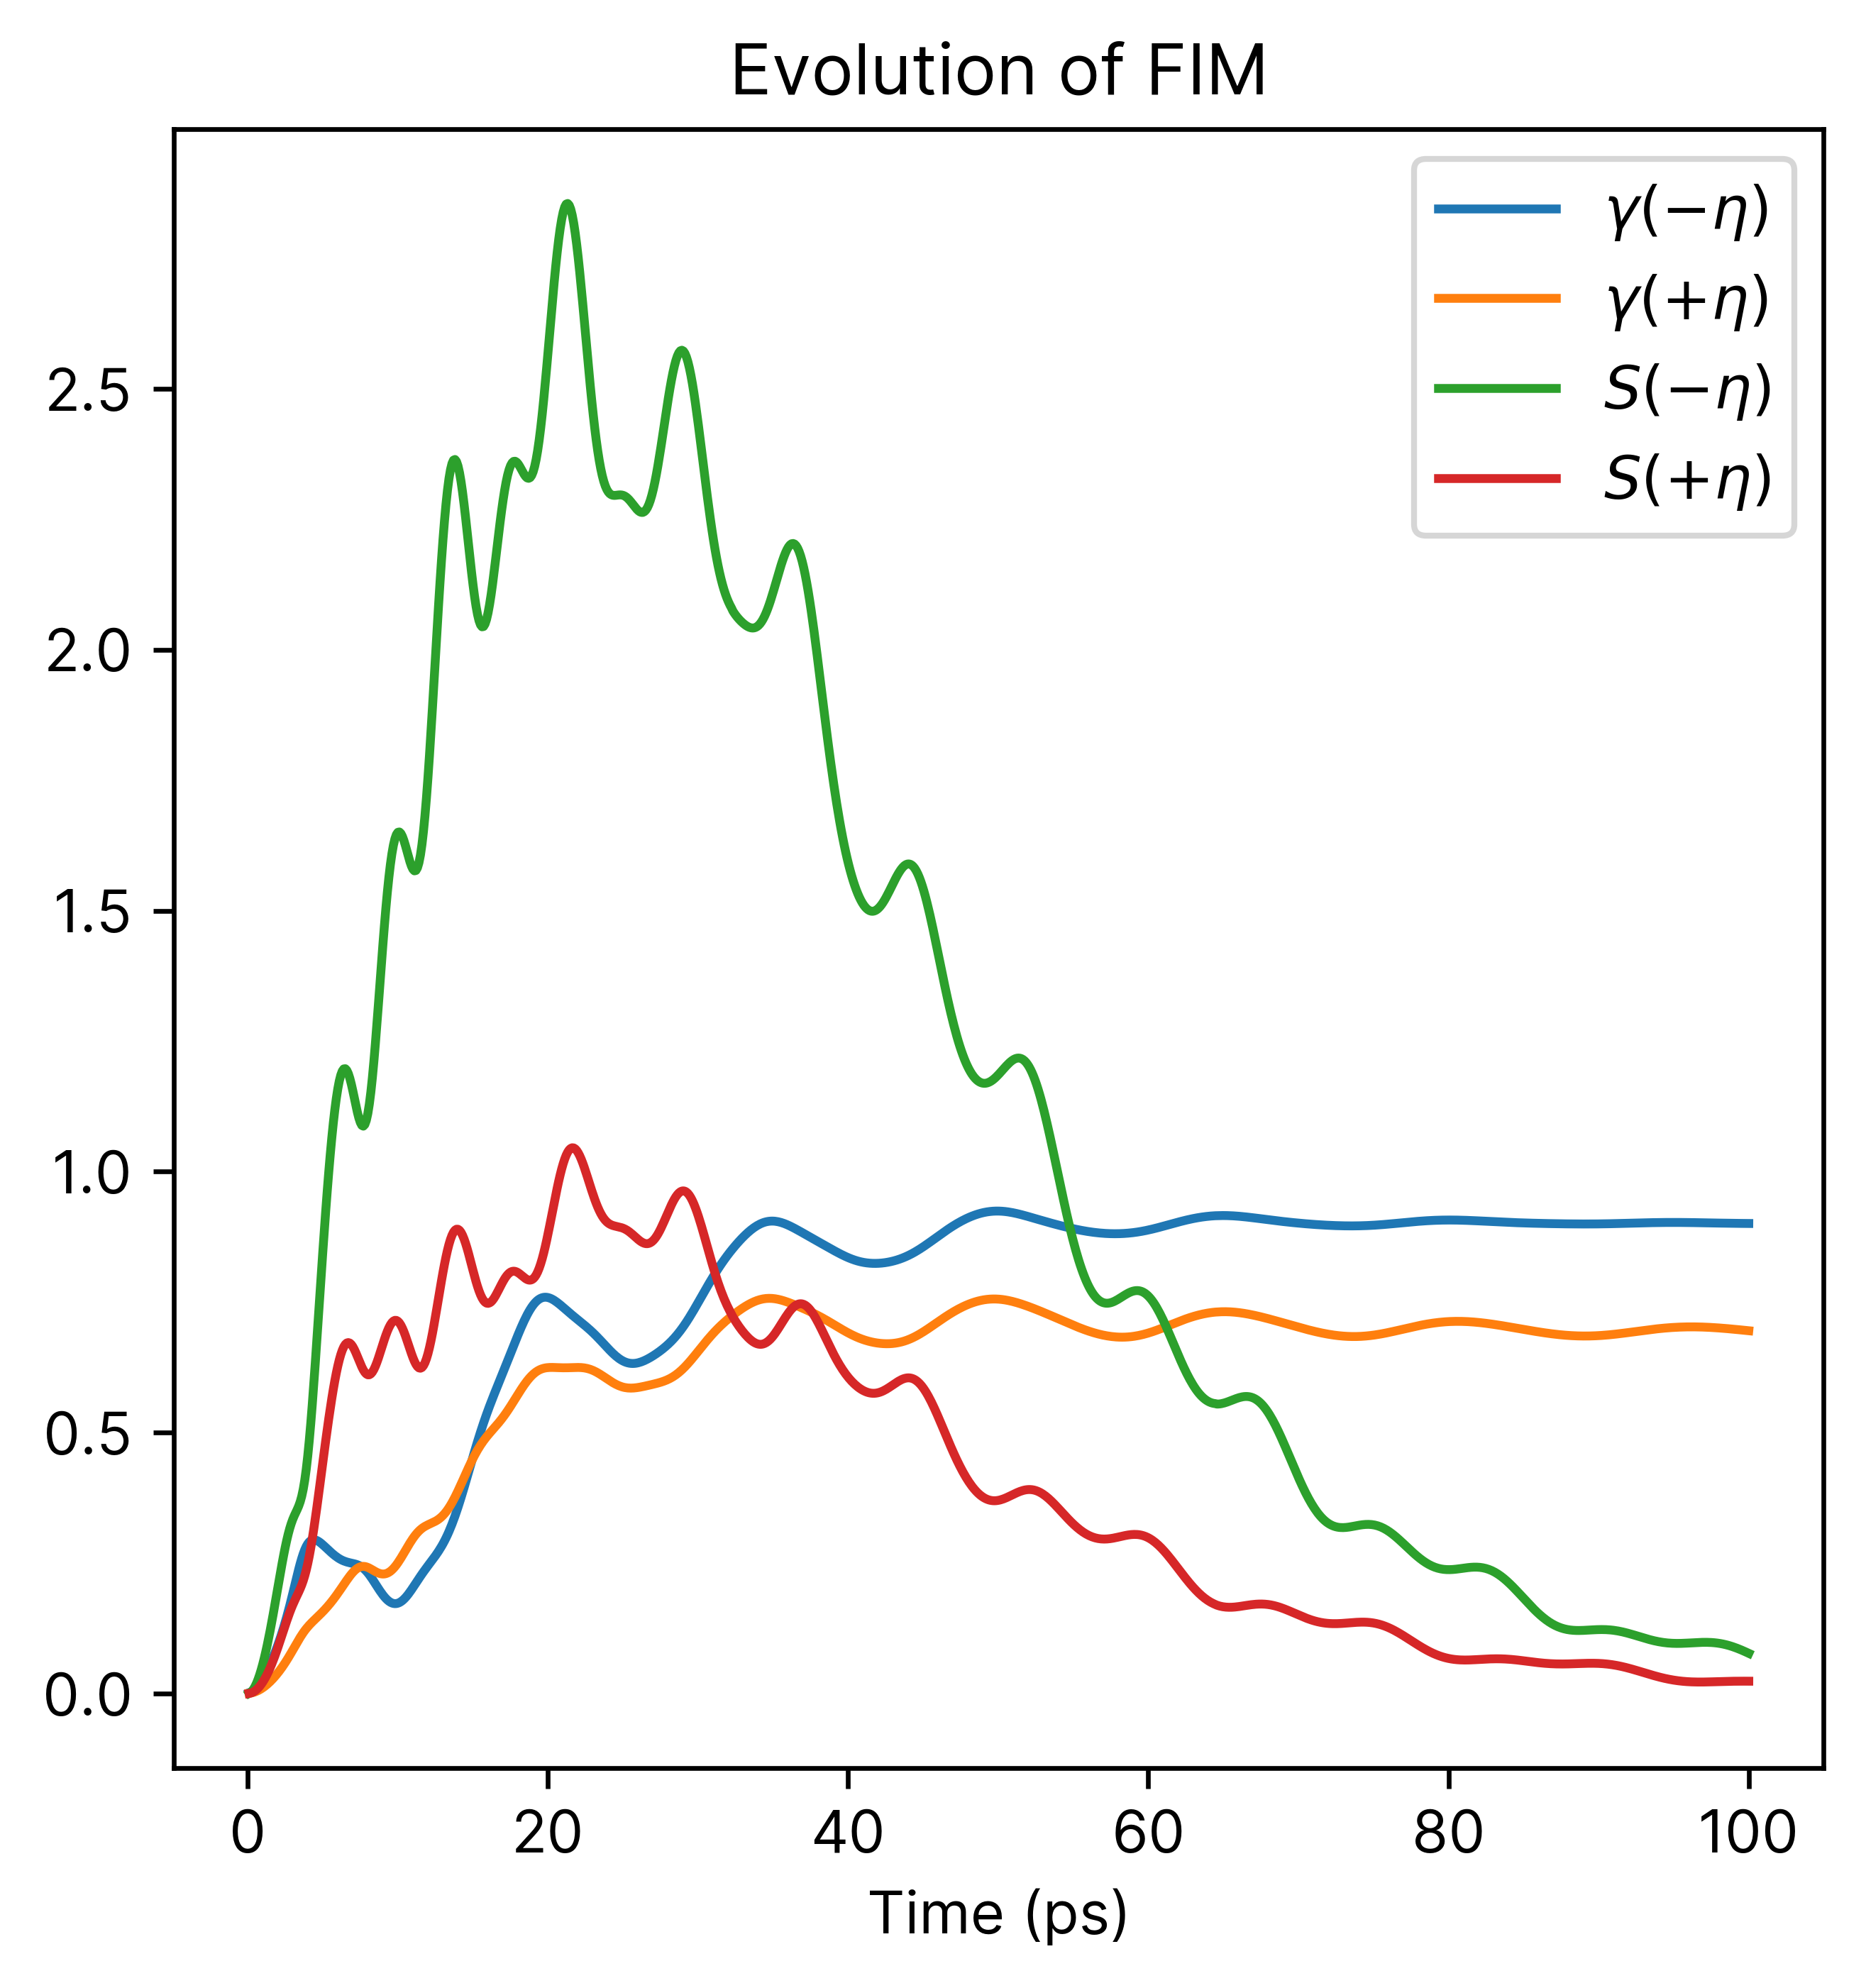

In [140]:
plt.figure(figsize=(5, 5), dpi=600)
for i in range(4):
    plt.plot(times, fim_times[:, i, i], label=names_true[i])

plt.title("Evolution of FIM")
plt.xlabel("Time (ps)")
plt.legend()
plt.show()

# Two dots (choi)

In [144]:
from functools import reduce


list_ket_ii = [qt.tensor(qt.basis(2, i), qt.basis(2, i)) for i in range(2)]

ket_ii = reduce(lambda i, j: i + j, list_ket_ii).unit()

maximally_entangled_dm = vec(
    qt.ket2dm(ket_ii).full()
)  # maximally entangled state (|omega><omega|)

In [148]:
m

two_qdots_identity_for_systemB(
  d=4,
  matrix_d=f32[4,4],
  positive_eps=1e-08,
  number_of_parameters=4,
  delta=0.12739334807998307,
  Omega=0.5,
  one_dot_system_hamiltonian=f32[2,2],
  A=i32[2,2],
  POVM_arr=i32[],
  basis_elements=f32[4,4]
)

In [150]:
times = jnp.linspace(0, 100, 1000)

initial_dm = maximally_entangled_dm

m_choi = two_qdots_identity_for_systemB(POVM_array=jnp.array(sic_povm(4)))


evolved_lkl = jax.vmap(
    lambda t: m_choi.likelihood_particle(true_pars, t, initial_dm)
)(times)

fim_times = jax.vmap(lambda t: m_choi.fim(true_pars, t, initial_dm))(times)

qfim_times = jax.vmap(lambda t: m_choi.qfim(true_pars, t, initial_dm))(times)

det_fim_times = jax.vmap(lambda fim_i: jnp.linalg.det(fim_i))(fim_times)

Text(0.5, 0, 'Times (ps)')

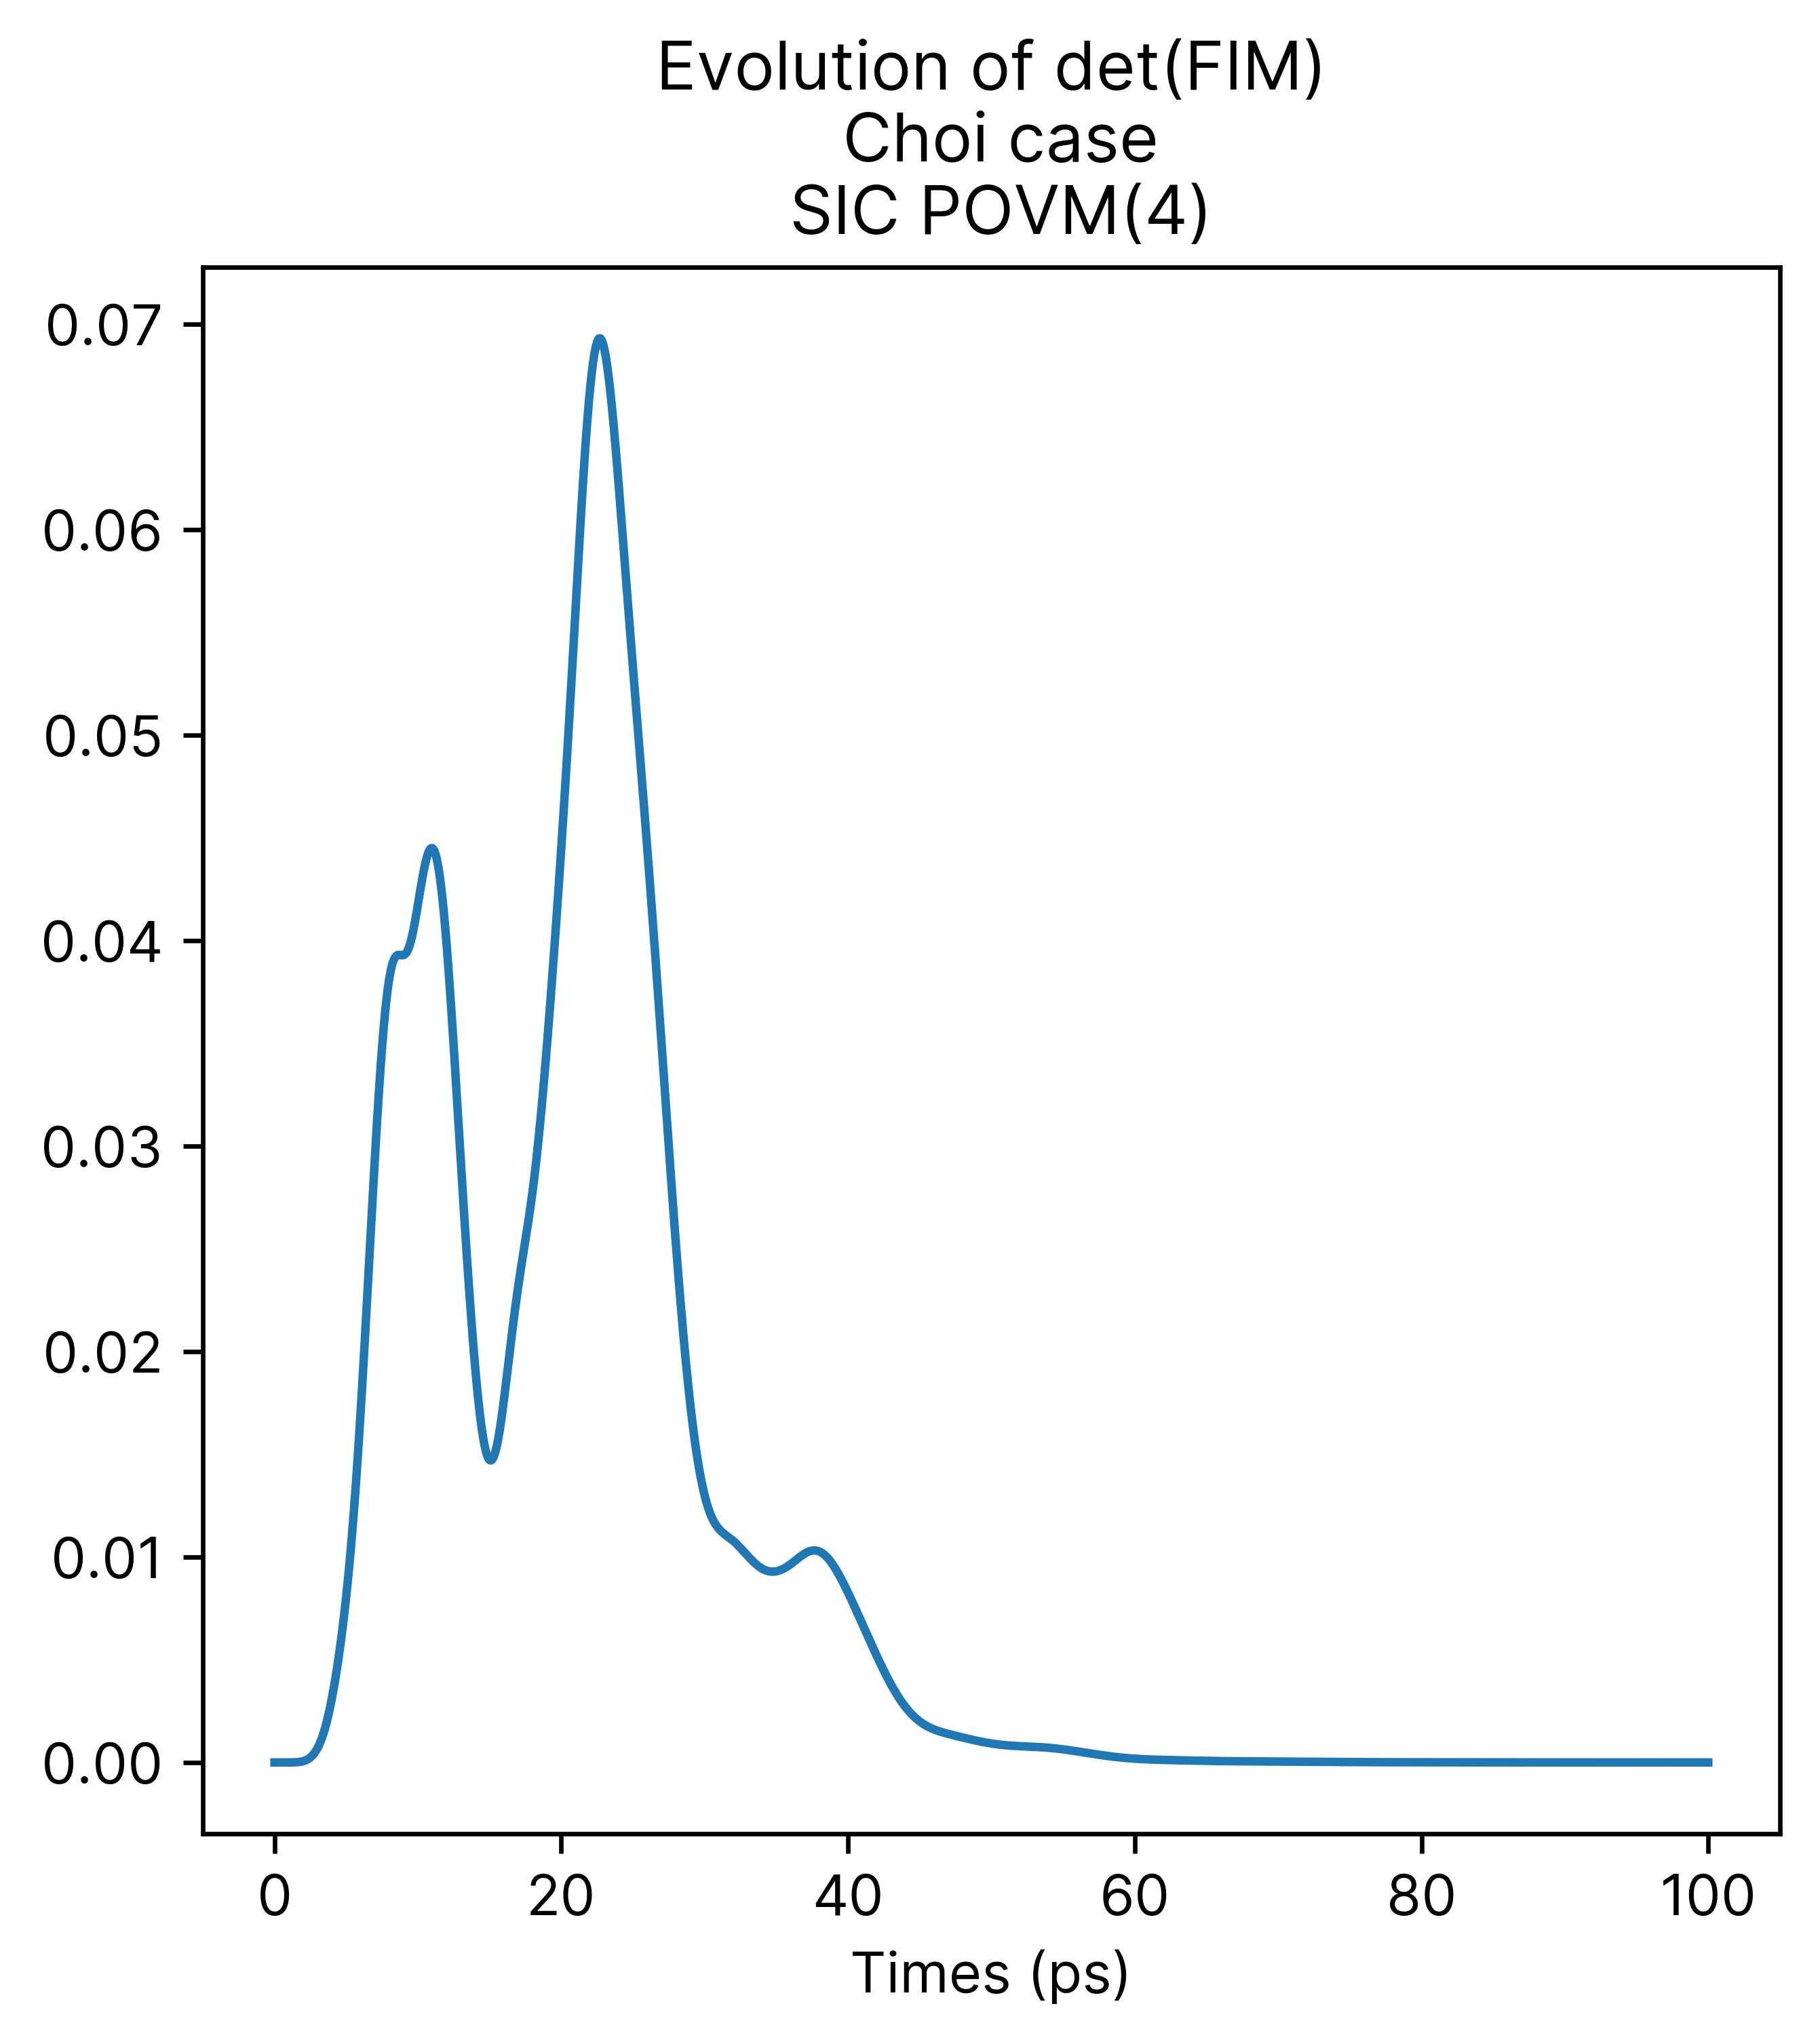

In [156]:
plt.figure(figsize=(5, 5), dpi=600)
plt.plot(times, det_fim_times)
plt.title("Evolution of det(FIM)\n Choi case\n SIC POVM(4)")

plt.xlabel("Times (ps)")
# plt.ylim(-1, 1)

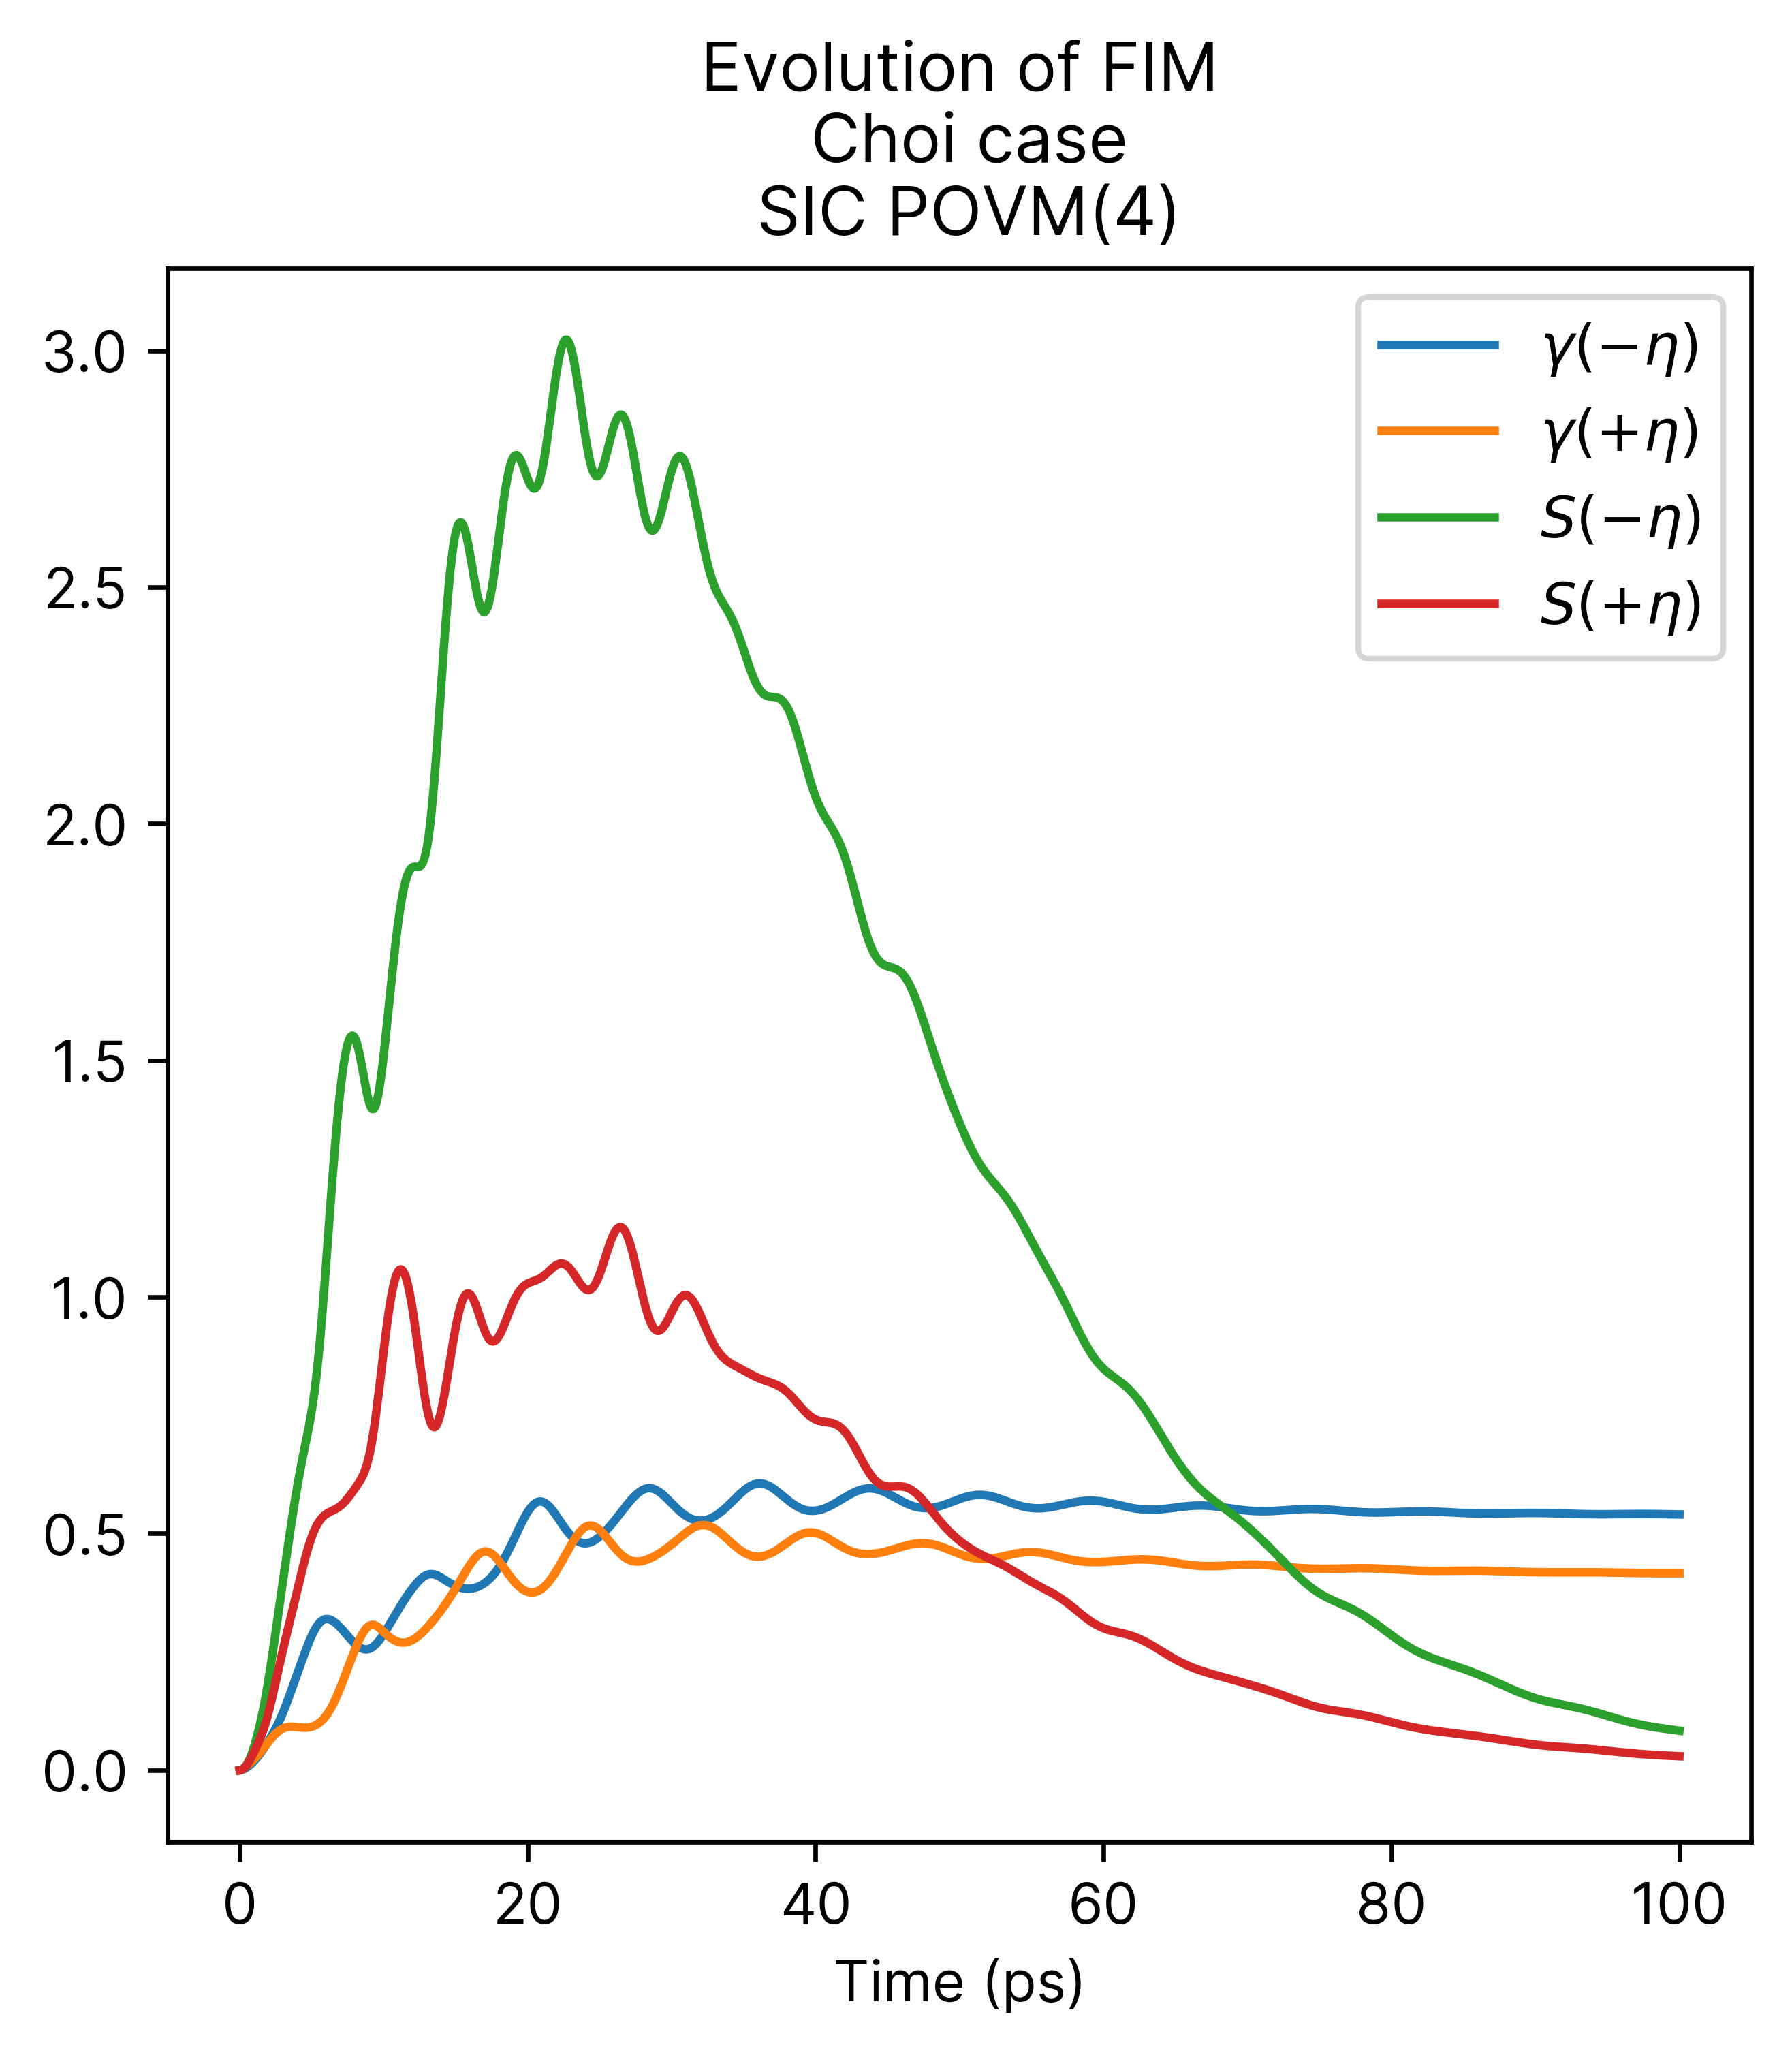

In [151]:
plt.figure(figsize=(5, 5), dpi=600)
for i in range(4):
    plt.plot(times, fim_times[:, i, i], label=names_true[i])

plt.title("Evolution of FIM\n Choi case\n SIC POVM(4)")
plt.xlabel("Time (ps)")
plt.legend()
plt.show()

In [162]:
times_for_avg = jnp.linspace(0, 40, 10000)
weights = 1 / 10000

det_fim_at_times = jax.vmap(
    lambda t: jnp.linalg.det(m_choi.fim(true_pars, t, initial_dm))
)(times_for_avg)

In [163]:
weights

0.0001

In [165]:
1 / 0.02524

39.61965134706815

In [164]:
(det_fim_at_times * weights).sum()

Array(0.0252452, dtype=float32)